# How hashtags and captions change the perception and position of your brand on Instagram??
 ## Using NLP to correlate the use of hashtags and captions for different fashion brands.


<div>
<img src="just.jpg" width="600"/>
</div>

Hashtags are tags linked through different platforms. A proper hashtag is a visual component of an ad that can be used across different social networks to promote continuity of a campaign. 

Brands usually care about hashtags because these can reinforce a brand's position and promote customers' familiarity with it, which has an impact in the early stages of the buying cycle. But can the use of hashtags (or captions) create an incorrect image of your brand? Let's say that you have a clothing brand in the category of designer, could the use of hashtags allude to another category of clothing? My goal is to use NLP to find how the use of captions and Instagram hashtags correlate across different brands and brand categories.

Data obtained from the project https://arxiv.org/abs/1704.04137. In their data project they obtained 24,752 Instagram posts by 13,350 people on Instagram. The data collection was done over a month period in January 2015. And in all the posts renowned fashion brand is named in the hashtags.

The data includes:
- Basic information of the posts (brand name, brand category, likes, comments, user id, followings, followers, captions, hashtags, and creation time).
- Learned features from their model (identifies the kind of picture). 
- Learned features from Microsoft emotion API (identifies the emotion of the people that appears in the picture)


### First step: installing all the packages and getting the data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np 
import re
from string import digits 
import spacy
import en_core_web_sm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
%matplotlib inline

print('Loading words, spacy, punktd, stopwords')
nltk.download('words')
nlp = en_core_web_sm.load()
words = set(nltk.corpus.words.words())
nltk.download('stopwords')
nltk.download('punkt')
print('done, now loading text and basic formating of columns name')
# Read dataset and format texts 
df = pd.read_csv(r'fashion data on instagram.csv', index_col=0)

#Formating column and brand names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandname = df.brandname.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandcategory = df.brandcategory.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
print('ready!!')
text_df=df[['brandcategory','hashtags','caption','brandname']]#.sample(frac=0.5, replace=True, random_state=1)
text_df['comments'] = np.ceil(np.log10(df['comments']))
text_df['likes'] = np.ceil(np.log10(df['likes']))
text_df=text_df[~text_df['hashtags'].isnull()]  
text_df=text_df[~text_df['caption'].isnull()]  

Loading words, spacy, punktd, stopwords


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


done, now loading text and basic formating of columns name
ready!!


C:\Users\thalia\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\thalia\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\thalia\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Cleaning the data and preparing for clustering:
My function cleaning is used to clean the text in a given column. Function tokenize also used.

After the data is cleaned. I used TDIFVectorizer to transform the text in a vector, with the frequencies of the words, that I will use for the cluster.

In [2]:
def cleaning(frame,col):
    """ 
    Function to clean text from a column in a data frame 
  
    This funtion removes non alphabethic characters,stop words and numerical characters and return text in lowers. 
  
    Parameters: 
    Data frame, text column 
  
    Returns: 
    obj clean text from column
  
    """
    newframe=frame.copy()  
    newframe=newframe[~newframe[col].isnull()]   
    punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','#',"%"]
    stop_words = text.ENGLISH_STOP_WORDS.union(punc)
    newframe[col]=newframe[col].str.replace('\d+', '').str.replace('\W', ' ').str.lower().str.replace(r'\b(\w{1,3})\b', '')
    newframe['Cleantext'] = [' '.join([w for w in x.lower().split() if w not in stop_words]) for x in newframe[col].tolist()] 
    newframe['Cleantext'] =[' '.join(word for word in x.lower().split() if not word.startswith('uf')if not word.startswith('ue')if not word.startswith('u0')) for x in newframe[col].tolist()] 
    content = newframe['Cleantext'].values
    return content

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]

clean_hashtags=cleaning(text_df,'hashtags')
clean_caption=cleaning(text_df,'caption')

### Pipeline to run the TFIDF and meanshift for captions and hashtags

In [3]:
pipeline = Pipeline(
  steps=[
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=50, max_df=.35, norm='l2', max_features=100,)),
    ('trans', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('clust', MeanShift(bandwidth=.95, n_jobs = -1,cluster_all=False))
  ])

pipeline.fit(clean_caption)
text_df['cluster_captions'] = pipeline.named_steps['clust'].labels_


C:\Users\thalia\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [4]:
def plotclusterscorr(df,col_of_int,clustername):
    """
    This function plots correlation between clustes and a given column using matplot. 
  
    Parameters: 
    df : pandas data frame
    col_of_int (str) :string with the name of the column to correlate with clusters
    clustername (str): name of cluster to correlate
    Returns: plot using matplotlib
    """  
    clusters = df.groupby([clustername,col_of_int]).size()
    fig2, ax2 = plt.subplots(figsize = (10,8))
    sns.heatmap(clusters.unstack(level = col_of_int), ax = ax2, cmap = 'Blues')

    ax2.set_xlabel(col_of_int, fontdict = {'weight': 'bold', 'size': 2})
    ax2.set_ylabel(clustername, fontdict = {'weight': 'bold', 'size': 24})
    for label in ax2.get_xticklabels():
        label.set_size(12)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")

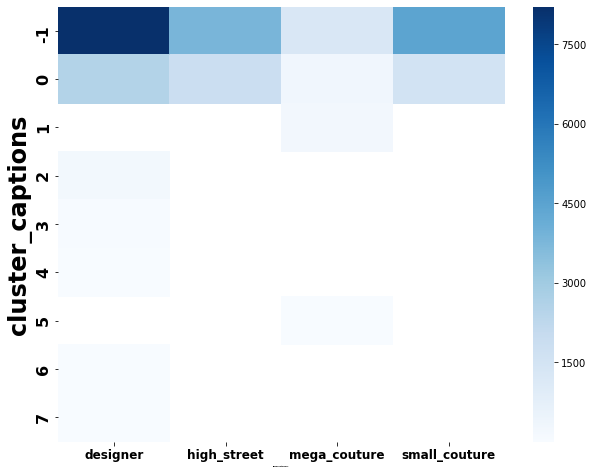

In [5]:
plotclusterscorr(text_df,'brandcategory','cluster_captions')

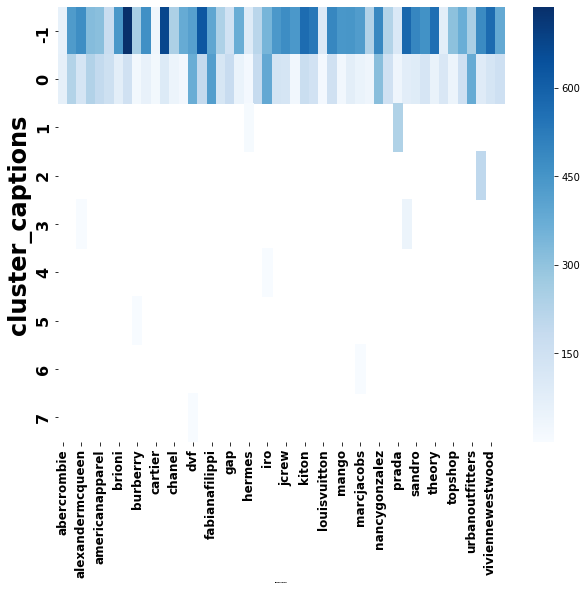

In [6]:
plotclusterscorr(text_df,'brandname','cluster_captions')

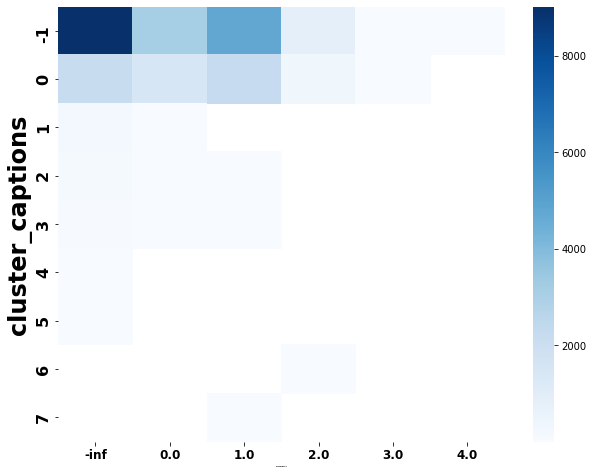

In [7]:
plotclusterscorr(text_df,'comments','cluster_captions')

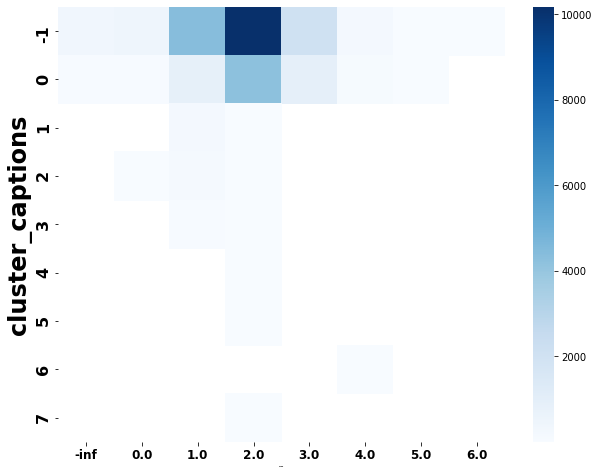

In [8]:
plotclusterscorr(text_df,'likes','cluster_captions')

C:\Users\thalia\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


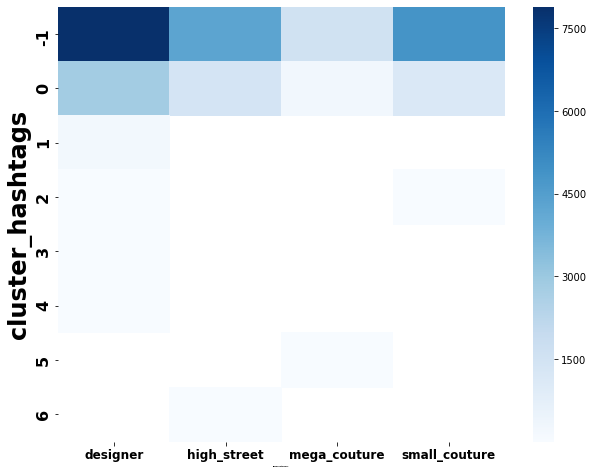

In [9]:
pipeline.fit(clean_hashtags)
text_df['cluster_hashtags'] = pipeline.named_steps['clust'].labels_
plotclusterscorr(text_df,'brandcategory','cluster_hashtags')

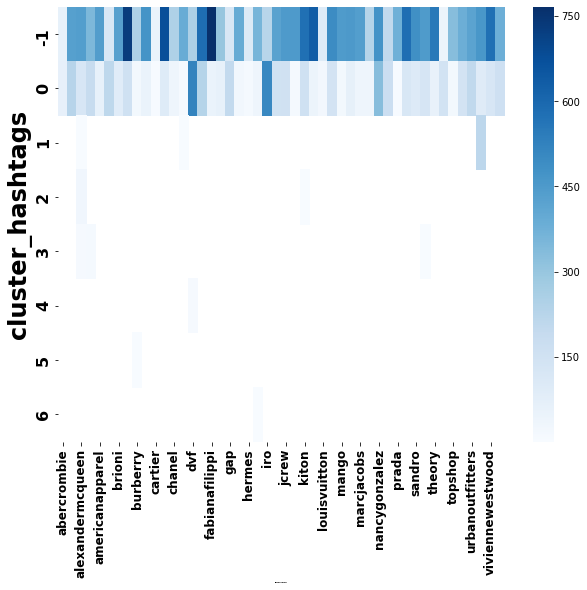

In [10]:
plotclusterscorr(text_df,'brandname','cluster_hashtags')

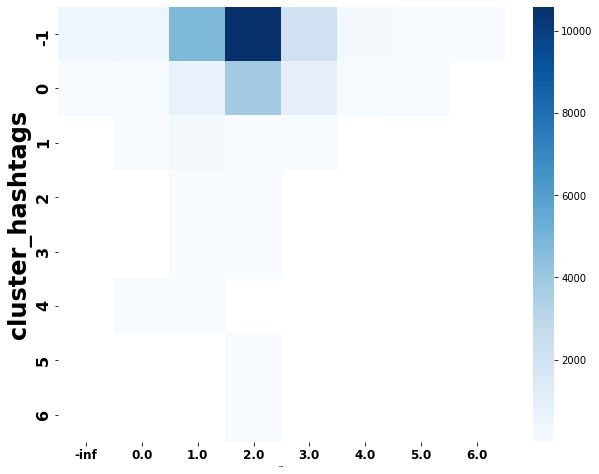

In [11]:
plotclusterscorr(text_df,'likes','cluster_hashtags')

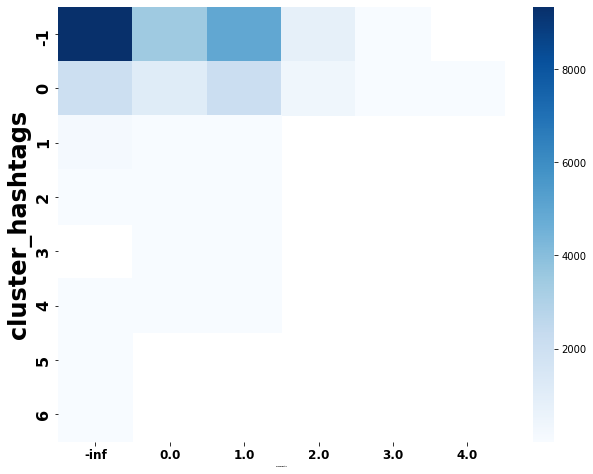

In [12]:
plotclusterscorr(text_df,'comments','cluster_hashtags')